In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import pickle
from shapely.geometry import shape, Point
import rasterio.features
from osgeo import gdal, osr
from shapely.wkt import loads

import warnings
warnings.filterwarnings('ignore')

/Users/lizjohnson/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.11.0-CAPI-1.17.0). Conversions between both will be slow.
  warnings.warn(
/var/folders/9f/7xdrpjw15kn4wccwzb5xhr0m0000gn/T/ipykernel_19733/1062876411.py:4: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to S

# Step 1: Convert KDE Output from array to raster

In [2]:
# Import the KDE pickle file
with open('../../CapstoneData/KDE_output_200m.pickle', 'rb') as f:
    kde_200 = pickle.load(f)

kde_200.shape

(9434, 8811)

In [3]:
kde_200.sum()

0.10990778711842207

In [4]:
#import brooklyn's boundary shape
bk_bndry = gpd.read_file('../Data/BrooklynBoundary.shp')
bk_bndry = bk_bndry.to_crs(32618)
bk_bndry.head()

,FID,geometry
0,0,"MULTIPOLYGON (((584478.960 4491458.524, 584470..."


In [5]:
bk_bndry.area

0    1.795793e+08
dtype: float64

$179,579,300 m^2$ of area in Brooklyn. That is 179,579,300 meters in the x and y direction. We could try to sample every 2 or 5 meters. That would leave us sampling 89,789,650 meters in both directions or 35,915,860 respectively.

In [37]:
#import tracts
nyc_tracts = pd.read_csv('../Data/2020_Census_Tracts_-_Tabular.csv')
nyc_tracts['the_geom'] = nyc_tracts['the_geom'].apply(loads)

# Convert the pandas DataFrame to a GeoDataFrame
tracts_gdf = gpd.GeoDataFrame(nyc_tracts, geometry='the_geom', crs = '4326')
tracts_gdf = tracts_gdf.to_crs(32618)
bk_tracts = tracts_gdf[tracts_gdf['BoroName'] == 'Brooklyn'].reset_index(drop = True)
bk_tracts.head()

,the_geom,CTLabel,BoroCode,BoroName,CT2020,BoroCT2020,CDEligibil,NTAName,NTA2020,CDTA2020,CDTANAME,GEOID,Shape_Leng,Shape_Area
0,"MULTIPOLYGON (((585247.472 4506029.684, 585252...",1.00,3,Brooklyn,100,3000100,NaN,Brooklyn Heights,BK0201,BK02,BK02 Downtown Brooklyn-Fort Greene (CD 2 Appro...,36047000100,6611.443960,2.224101e+06
1,"MULTIPOLYGON (((584007.655 4500982.266, 583958...",2.00,3,Brooklyn,200,3000200,NaN,Sunset Park (West),BK0702,BK07,BK07 Sunset Park-Windsor Terrace (CD 7 Approxi...,36047000200,9075.285121,2.952085e+06
2,"MULTIPOLYGON (((584966.437 4505778.759, 584940...",3.01,3,Brooklyn,301,3000301,NaN,Brooklyn Heights,BK0201,BK02,BK02 Downtown Brooklyn-Fort Greene (CD 2 Appro...,36047000301,6525.111338,2.164337e+06
3,"MULTIPOLYGON (((585075.427 4505660.913, 585012...",5.01,3,Brooklyn,501,3000501,NaN,Brooklyn Heights,BK0201,BK02,BK02 Downtown Brooklyn-Fort Greene (CD 2 Appro...,36047000501,4828.170276,9.015070e+05
4,"MULTIPOLYGON (((585215.411 4505612.714, 585223...",5.02,3,Brooklyn,502,3000502,NaN,Brooklyn Heights,BK0201,BK02,BK02 Downtown Brooklyn-Fort Greene (CD 2 Appro...,36047000502,4902.479685,1.041529e+06


In [7]:
camera_locs = pd.read_csv('../Data/aggregated_camera_locs.csv',index_col = 0)
camera_locs['geometry'] = camera_locs['geometry'].apply(loads)
camera_locs = gpd.GeoDataFrame(camera_locs,geometry = 'geometry', crs = '4326')
camera_locs = camera_locs.to_crs(32618)
camera_locs['x'] = camera_locs.geometry.x
camera_locs['y'] = camera_locs.geometry.y
camera_locs.head()

,Data_Source,Camera_Count,geometry,x,y
0,Amnesty,5,POINT (588147.072 4505188.861),588147.071612,4.505189e+06
1,Amnesty,5,POINT (586867.513 4498122.217),586867.512967,4.498122e+06
2,Amnesty,1,POINT (587375.934 4506652.088),587375.933703,4.506652e+06
3,Amnesty,7,POINT (592666.168 4502926.211),592666.167996,4.502926e+06
4,Amnesty,1,POINT (587913.940 4503283.593),587913.939630,4.503284e+06


In [8]:
output_raster_path = '../../CapstoneData/KDE_200m_raster_output.tif'

In [9]:
#convert to raster to use with geo shape files
# Define the minimum and maximum bounds of the raster
#change this to the bk boundary shapefile
min_x, min_y, max_x, max_y = bk_bndry.total_bounds

width = kde_200.shape[1]
height = kde_200.shape[0]
pixel_width = (max_x - min_x) / width
pixel_height = (max_y - min_y) / height
#define spatial reference
srs = osr.SpatialReference()
srs.ImportFromEPSG(32618) 
#create raster
driver = gdal.GetDriverByName('GTiff')
output_raster = driver.Create(output_raster_path, width, height, 1, gdal.GDT_Float32)

# Set the raster's geotransform (georeferencing information)
output_raster.SetGeoTransform((min_x, pixel_width, 0, max_y, 0, -pixel_height))

# Set the raster's spatial reference system (SRS)
if srs is not None:
    output_raster.SetProjection(srs.ExportToWkt())

# Write the array data to the raster
band = output_raster.GetRasterBand(1)
band.WriteArray(kde_200)

# Save and close the raster file
output_raster.FlushCache()
output_raster = None

In [10]:
x_grid, y_grid = np.meshgrid(np.linspace(min_x, max_x,width),
                             np.linspace(min_y, max_y, height))
levels = np.linspace(0, kde_200.max(), 25)

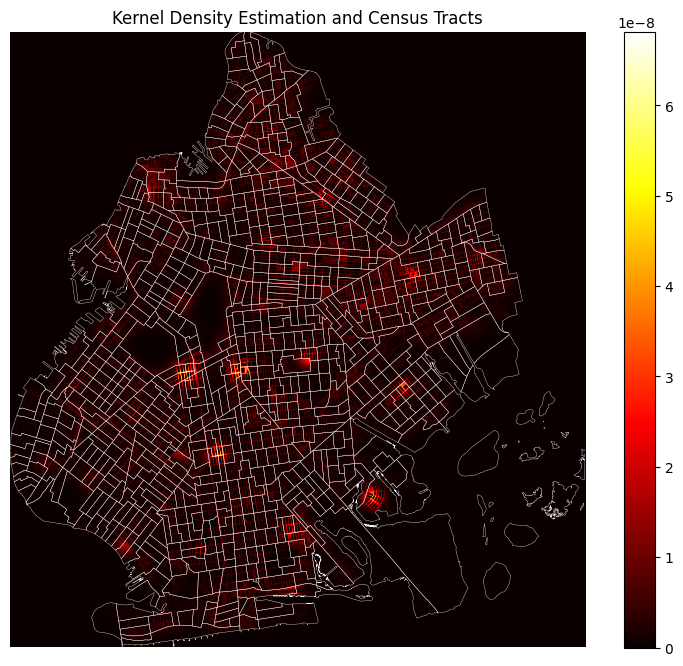

In [11]:
#check output
# Open the saved raster file
with rasterio.open(output_raster_path) as src:
    raster_array = src.read(1)

# Plot the raster array
fig, ax = plt.subplots(figsize=(10, 8))
raster_image = ax.imshow(raster_array, cmap='hot',extent=[min_x, max_x, min_y, max_y])
# Plot the bk_boundary geodataframe
bk_tracts.plot(ax=ax, facecolor='none', edgecolor='white',linewidth = 0.25)
fig.colorbar(raster_image, ax=ax)
ax.set_title('Kernel Density Estimation and Census Tracts')
ax.axis('off')
fig.savefig('../Outputs/raster_KDE200m_tracts_overlay.png',bbox_inches = 'tight')
plt.show()

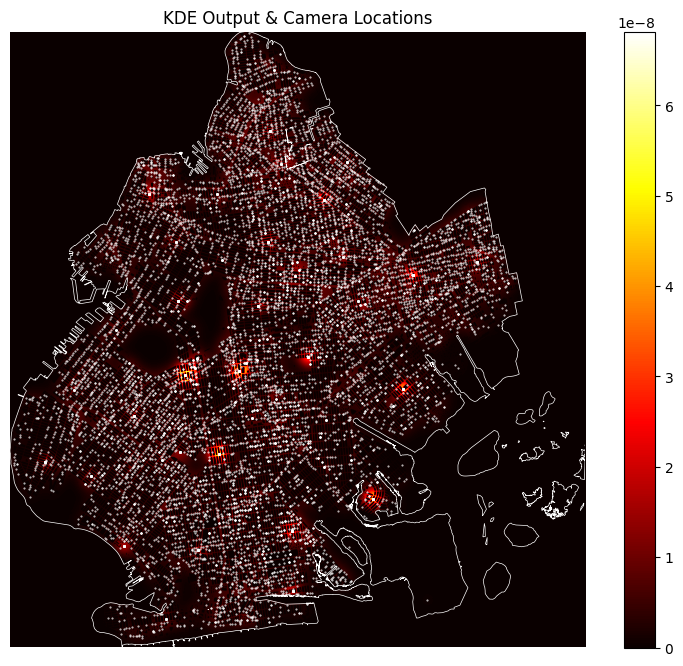

In [12]:
# Plot the raster array and camera points
fig, ax = plt.subplots(figsize=(10, 8))

raster_image = ax.imshow(raster_array, cmap='hot',extent=[min_x, max_x, min_y, max_y])
# Plot the bk_boundary geodataframe
camera_locs.plot(ax=ax,color='white',alpha = 0.8, markersize = 0.25)
bk_bndry.plot(ax=ax, facecolor='none', edgecolor='white',linewidth = 0.5)
fig.colorbar(raster_image, ax=ax)
ax.set_title('KDE Output & Camera Locations')
ax.axis('off')
fig.savefig('../Outputs/raster_KDE200m_cameras_overlay.png',bbox_inches = 'tight')
plt.show()

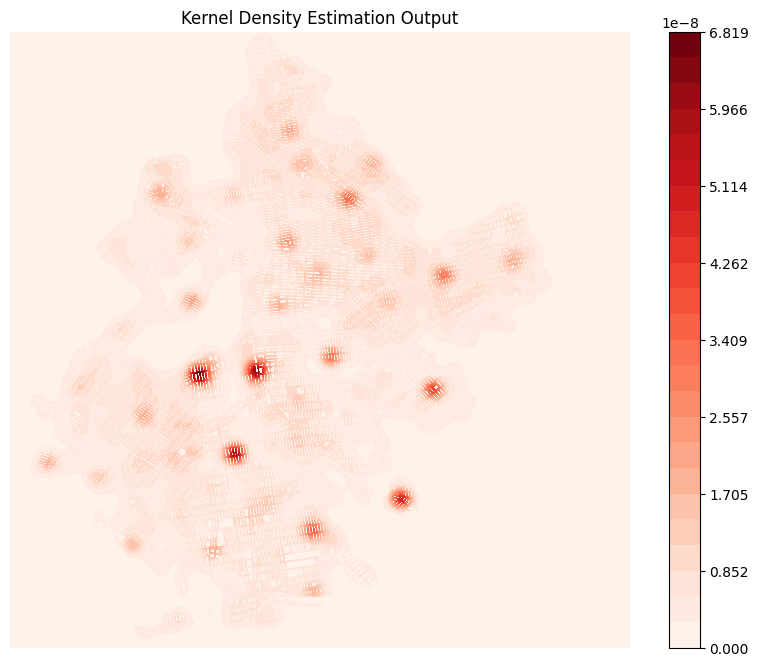

In [13]:
# Plot the array contour map
fig, ax = plt.subplots(figsize=(10, 8))
contour = ax.contourf(x_grid, y_grid[::-1], kde_200, levels=levels, cmap=plt.cm.Reds)
# bk_tracts.plot(ax=ax, facecolor='none', edgecolor='black',linewidth = 0.25)
# Set title and color bar
ax.set_title('Kernel Density Estimation Output')
ax.axis('off')
fig.colorbar(contour, ax=ax)
plt.savefig('../Outputs/KDE_Output_Heatmap.png',bbox_inches = 'tight')
plt.show()

# Step 2: Sample random points from polygons to compute neighborhood surveillance load

In [14]:
from rasterio.mask import mask
from rasterio.plot import show
from shapely.geometry import mapping

In [15]:
# Load the raster file
raster = rasterio.open(output_raster_path)
type(raster)

rasterio.io.DatasetReader

In [16]:
def sample_points_within_geom(geometry, num_points):
    """
    Function to sample random points within each geometry of a geodataframe
    """
    bbox = geometry.bounds
    min_x, min_y, max_x, max_y = bbox

    points = []  # Initialize 'points' as an empty list

    if num_points == None:
        area_m2 = geometry.area
        #sample points for every 5m or every 25 sq m
        num_points = round(area_m2 / 25)
        
    while len(points) < num_points:
        # Generate random points within the bounding box of the tract
        random_x = np.random.uniform(min_x, max_x)
        random_y = np.random.uniform(min_y, max_y)
        point = (random_x, random_y)

        # Check if the random point falls within the tract
        if geometry.contains(Point(point)):
            points.append(point)

    return points

In [32]:
# num_points_per_tract = 1000  # Adjust the number of points per tract as needed
values_per_tract = []

for i, tract in bk_tracts.iterrows():
    tract_geometry = tract['the_geom']
    column_dict = {'GEOID': tract['GEOID']}
    # Sample points within the current tract
    points = sample_points_within_geom(tract_geometry,100)
     # Initialize lists to store the values for each point
    values = []
    for point in points:
        # Perform the raster masking to extract values at the point
        masked_data, _ = mask(raster, [mapping(Point(point))], crop=True)

        # Flatten the masked data to a 1D array
        value = masked_data.flatten()
        values.append(value)

    # Compute the average and standard deviation of the values and add them to dictionary       
    column_dict['avg_value'] = np.mean(values)
    column_dict['std_dev_value'] = np.std(values)
    
    values_per_tract.append(column_dict)

In [40]:
# Perform the sampling and analysis as described in the previous code
values_per_geom = []
id_col = 'GEOID'

for i, row in bk_tracts.iterrows():
    geom = row['the_geom']

    # Perform the raster masking to extract values at the points
    masked_data, _ = mask(raster, [mapping(geom)], crop=True)

    # Flatten the masked data to a 1D array
    values = masked_data.flatten()

    # Compute the average and standard deviation of the values
    avg_value = np.mean(values)
    std_dev_value = np.std(values)

    values_per_geom.append({id_col: row[id_col],
                            'avg_value': avg_value,
                            'std_dev_value': std_dev_value,
                           'sample_size': len(values)})

# Create a new GeoDataFrame from the results and join it with the original GeoDataFrame
results_df = pd.DataFrame(values_per_geom)
results_gdf = bk_tracts.merge(results_df, on=id_col)

#scale the values to be between 0 and 1
data = np.asarray(results_gdf['avg_value']).reshape(-1, 1) * 10000
scaler = MinMaxScaler()
scaler.fit(data)
y_data = scaler.transform(data)
std_data = scaler.transform(np.asarray(results_gdf['std_dev_value']).reshape(-1, 1)* 10000)

results_gdf['avg_value_scaled'] = y_data
results_gdf['std_dev_scaled'] = std_data

# Create quartile buckets based on avg_value_scaled
quartiles = np.percentile(results_gdf['avg_value_scaled'], [25, 50, 75])
results_gdf['quartile_buckets'] = pd.cut(
    results_gdf['avg_value_scaled'],
    bins=[0, *quartiles, 1],
    labels=['Q1', 'Q2', 'Q3', 'Q4']
)
# Create quartile labels based on quartile_buckets
results_gdf['quartile_labels'] = results_gdf['quartile_buckets'].map({
    'Q1': 'Bottom 25%',
    'Q2': 'Bottom 25% to Median',
    'Q3': 'Median to Top 25%',
    'Q4': 'Top 25%'
})

In [41]:
results_gdf.head()

,the_geom,CTLabel,BoroCode,BoroName,CT2020,BoroCT2020,CDEligibil,NTAName,NTA2020,CDTA2020,...,GEOID,Shape_Leng,Shape_Area,avg_value,std_dev_value,sample_size,avg_value_scaled,std_dev_scaled,quartile_buckets,quartile_labels
0,"MULTIPOLYGON (((585247.472 4506029.684, 585252...",1.00,3,Brooklyn,100,3000100,NaN,Brooklyn Heights,BK0201,BK02,...,36047000100,6611.443960,2.224101e+06,1.711508e-09,2.886487e-09,95937,0.118447,0.199763,Q3,Median to Top 25%
1,"MULTIPOLYGON (((584007.655 4500982.266, 583958...",2.00,3,Brooklyn,200,3000200,NaN,Sunset Park (West),BK0702,BK07,...,36047000200,9075.285121,2.952085e+06,9.131503e-10,1.816372e-09,160820,0.063196,0.125704,Q1,Bottom 25%
2,"MULTIPOLYGON (((584966.437 4505778.759, 584940...",3.01,3,Brooklyn,301,3000301,NaN,Brooklyn Heights,BK0201,BK02,...,36047000301,6525.111338,2.164337e+06,9.005784e-10,1.460793e-09,94458,0.062326,0.101096,Q1,Bottom 25%
3,"MULTIPOLYGON (((585075.427 4505660.913, 585012...",5.01,3,Brooklyn,501,3000501,NaN,Brooklyn Heights,BK0201,BK02,...,36047000501,4828.170276,9.015070e+05,7.750919e-10,2.257502e-09,50568,0.053641,0.156233,Q1,Bottom 25%
4,"MULTIPOLYGON (((585215.411 4505612.714, 585223...",5.02,3,Brooklyn,502,3000502,NaN,Brooklyn Heights,BK0201,BK02,...,36047000502,4902.479685,1.041529e+06,2.378376e-09,5.227909e-09,48573,0.164598,0.361803,Q4,Top 25%


<Axes: >

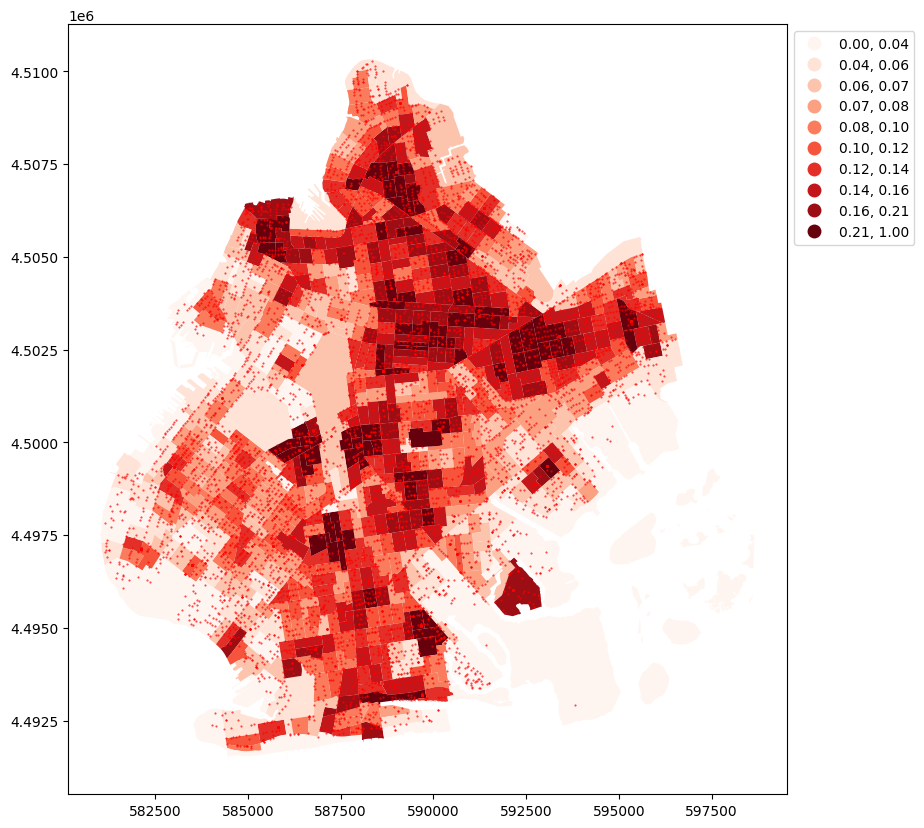

In [42]:
fig, ax = plt.subplots(figsize = (10,10))
results_gdf.plot(column = 'avg_value_scaled',ax = ax,cmap='Reds', legend = True,k = 10, scheme = 'Quantiles',
                missing_kwds={"color": "lightgrey", ## what to do with missing values
                                 "edgecolor": "red",
                                 "hatch": "///",
                                 "label": "Missing values",}
             ,legend_kwds={'bbox_to_anchor': (1, 1),'loc': 'upper left'})
camera_locs.plot(ax=ax,color='red',alpha = 0.8, markersize = 0.25)

In [43]:
bk_blks = gpd.read_file('../Data/BrooklynBlocks/BrooklynBlocks.shp')
bk_tracts = gpd.read_file('../Data/BrooklynTracts/BrooklynTracts.shp')
bk_bg = gpd.read_file('../Data/BrooklynBlockGroups/BrooklynBlockGroups.shp')
bk_nta = gpd.read_file('../Data/BrooklynNTAs/BrooklynNTAs.shp')

In [44]:
#change crs from 4326 to 
bk_blks = bk_blks.to_crs(32618)
bk_tracts = bk_tracts.to_crs(32618)
bk_bg = bk_bg.to_crs(32618)
bk_nta = bk_nta.to_crs(32618)

In [45]:
#check the columns of each dataframe so we can standardize
bk_blks.head()

,CB2020,BoroCode,BoroName,CT2020,BCTCB2020,GEOID,Shape_Leng,Shape_Area,geometry
0,1,3,Brooklyn,1801,30018010001,360470018010001,1061.915908,14961.031969,"MULTIPOLYGON (((584592.064 4502419.952, 584591..."
1,1,3,Brooklyn,1803,30018030001,360470018030001,4053.894954,83041.203647,"MULTIPOLYGON (((582738.379 4500475.968, 582748..."
2,1,3,Brooklyn,1804,30018040001,360470018040001,653.460985,3891.785188,"MULTIPOLYGON (((582168.929 4499738.822, 582146..."
3,1,3,Brooklyn,3400,30034000001,360470034000001,1292.527355,35171.987124,"POLYGON ((581453.732 4499145.540, 581447.007 4..."
4,1,3,Brooklyn,5301,30053010001,360470053010001,563.499018,6125.607515,"MULTIPOLYGON (((583014.760 4503038.093, 583010..."


In [46]:
bk_tracts.head()

,CTLabel,BoroCode,BoroName,CT2020,BoroCT2020,CDEligibil,NTAName,NTA2020,CDTA2020,CDTANAME,GEOID,Shape_Leng,Shape_Area,geometry
0,1.00,3,Brooklyn,100,3000100,None,Brooklyn Heights,BK0201,BK02,BK02 Downtown Brooklyn-Fort Greene (CD 2 Appro...,36047000100,6611.443960,2.224101e+06,"POLYGON ((585247.472 4506029.684, 585252.447 4..."
1,2.00,3,Brooklyn,200,3000200,None,Sunset Park (West),BK0702,BK07,BK07 Sunset Park-Windsor Terrace (CD 7 Approxi...,36047000200,9075.285121,2.952085e+06,"POLYGON ((584007.655 4500982.266, 583958.881 4..."
2,3.01,3,Brooklyn,301,3000301,None,Brooklyn Heights,BK0201,BK02,BK02 Downtown Brooklyn-Fort Greene (CD 2 Appro...,36047000301,6525.111338,2.164337e+06,"POLYGON ((584966.437 4505778.759, 584940.848 4..."
3,5.01,3,Brooklyn,501,3000501,None,Brooklyn Heights,BK0201,BK02,BK02 Downtown Brooklyn-Fort Greene (CD 2 Appro...,36047000501,4828.170276,9.015070e+05,"POLYGON ((585075.427 4505660.913, 585012.652 4..."
4,5.02,3,Brooklyn,502,3000502,None,Brooklyn Heights,BK0201,BK02,BK02 Downtown Brooklyn-Fort Greene (CD 2 Appro...,36047000502,4902.479685,1.041529e+06,"POLYGON ((585215.411 4505612.714, 585223.049 4..."


In [47]:
bk_bg.head()

,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,GEOID,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,36,047,101200,1,360471012001,Block Group 1,G5030,S,80394,0,+40.6405425,-073.8945760,"POLYGON ((593266.299 4499421.090, 593339.922 4..."
1,36,047,101800,1,360471018001,Block Group 1,G5030,S,283765,0,+40.6438530,-073.8866450,"POLYGON ((593739.771 4500498.638, 593883.226 4..."
2,36,047,109800,1,360471098001,Block Group 1,G5030,S,266969,0,+40.6545238,-073.8975990,"POLYGON ((592977.020 4501007.097, 593042.260 4..."
3,36,047,077000,1,360470770001,Block Group 1,G5030,S,45845,0,+40.6347960,-073.9511877,"POLYGON ((588600.518 4498872.124, 588650.999 4..."
4,36,047,077200,1,360470772001,Block Group 1,G5030,S,124696,0,+40.6339173,-073.9541894,"POLYGON ((588264.268 4498819.944, 588342.444 4..."


In [48]:
bk_nta.head()

,boro_code,boro_name,county_fip,ntacode,ntaname,shape_area,shape_leng,geometry
0,3.0,Brooklyn,047,BK40,Windsor Terrace,1.404167e+07,19033.672066,"POLYGON ((586207.563 4501643.060, 586204.695 4..."
1,3.0,Brooklyn,047,BK50,Canarsie,8.208968e+07,43703.609666,"MULTIPOLYGON (((593990.695 4500133.738, 593989..."
2,3.0,Brooklyn,047,BK68,Fort Greene,1.648282e+07,19825.520859,"POLYGON ((587073.122 4505530.649, 587074.580 4..."
3,3.0,Brooklyn,047,BK79,Ocean Hill,2.008991e+07,22494.581245,"POLYGON ((592689.215 4503673.539, 592744.085 4..."
4,3.0,Brooklyn,047,BK44,Madison,2.737916e+07,26237.257649,"POLYGON ((589882.064 4495847.157, 589818.490 4..."


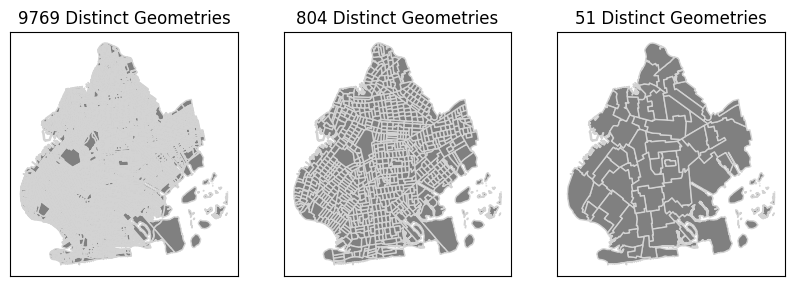

In [49]:
gdfs = [bk_blks, bk_tracts, bk_nta]
fig,ax = plt.subplots(1,3,figsize = (10,10))

for i,gdf in enumerate(gdfs):

    gdf.plot(ax = ax[i],facecolor = 'grey',edgecolor = 'lightgrey')
    ax[i].set_title('{} Distinct Geometries'.format(len(gdf)))
    # Turn off axes labels
    ax[i].set_xticks([])
    ax[i].set_yticks([])


The larger the geographical unit, the more points we should sample. Let's sample every 5 meters, similar to how we sampled for the KDE output. That means to calculate the number of points to sample, we have to calculate the area of a given geometry in squared meters, and divide by 25.

In [50]:
import json
from shapely.geometry import Polygon

# List to store the results

all_results = []

for gdf in gdfs:
    # Perform the sampling and analysis as described in the previous code
    values_per_geom = []

    if gdf is bk_nta:
        id_col = 'ntacode'
    else:
        id_col = 'GEOID'

    for i, row in gdf.iterrows():
        geom = row['geometry']

        # Perform the raster masking to extract values at the points
        masked_data, _ = mask(raster, [mapping(geom)], crop=True)

        # Flatten the masked data to a 1D array
        values = masked_data.flatten()

        # Compute the average and standard deviation of the values
        avg_value = np.mean(values)
        std_dev_value = np.std(values)

        values_per_geom.append({id_col: row[id_col],
                                'avg_value': avg_value,
                                'std_dev_value': std_dev_value,
                               'sample_size': len(values)})

    # Create a new GeoDataFrame from the results and join it with the original GeoDataFrame
    results_df = pd.DataFrame(values_per_geom)
    results_gdf = gdf.merge(results_df, on=id_col)

    #scale the values to be between 0 and 1
    data = np.asarray(results_gdf['avg_value']).reshape(-1, 1) * 10000
    scaler = MinMaxScaler()
    scaler.fit(data)
    y_data = scaler.transform(data)
    std_data = scaler.transform(np.asarray(results_gdf['std_dev_value']).reshape(-1, 1)* 10000)

    results_gdf['avg_value_scaled'] = y_data
    results_gdf['std_dev_scaled'] = std_data
    
    # Create quartile buckets based on avg_value_scaled
    quartiles = np.percentile(results_gdf['avg_value_scaled'], [25, 50, 75])
    results_gdf['quartile_buckets'] = pd.cut(
        results_gdf['avg_value_scaled'],
        bins=[0, *quartiles, 1],
        labels=['Q1', 'Q2', 'Q3', 'Q4']
    )
    # Create quartile labels based on quartile_buckets
    results_gdf['quartile_labels'] = results_gdf['quartile_buckets'].map({
        'Q1': 'Bottom 25%',
        'Q2': 'Bottom 25% to Median',
        'Q3': 'Median to Top 25%',
        'Q4': 'Top 25%'
    })
    
    rows = []

    # Iterate over each row in the GeoDataFrame
    for index, row in results_gdf.iterrows():
        # Create a dictionary for the current row
        row_dict = {
            'geojson': row.geometry.__geo_interface__,
            'results': row.drop('geometry').to_dict()
        }
        # Append the row dictionary to the list
        rows.append(row_dict)

    # Append the results to the list
    all_results.append(rows)

# Save the results to a JSON file
output_file = '../Outputs/KDE_sampling.json'
with open(output_file, 'w') as f:
    json.dump(all_results, f, indent=4)

In [51]:
# Open and read the JSON file
with open(output_file, 'r') as f:
    data = json.load(f)

print(type(data),len(data))

<class 'list'> 3


In [52]:
features = []
for item in data[2]:
    geometry = shape(item['geojson'])
    properties = item['results']
    features.append({"geometry": geometry, "properties": properties})

nta_surv = gpd.GeoDataFrame.from_features(features)
nta_surv.head()

,geometry,boro_code,boro_name,county_fip,ntacode,ntaname,shape_area,shape_leng,avg_value,std_dev_value,sample_size,avg_value_scaled,std_dev_scaled,quartile_buckets,quartile_labels
0,"POLYGON ((586207.563 4501643.060, 586204.695 4...",3.0,Brooklyn,047,BK40,Windsor Terrace,1.404167e+07,19033.672066,1.448168e-09,4.911048e-09,722880,0.491730,1.730452,Q3,Median to Top 25%
1,"MULTIPOLYGON (((593990.695 4500133.738, 593989...",3.0,Brooklyn,047,BK50,Canarsie,8.208968e+07,43703.609666,1.281708e-09,3.158630e-09,3305123,0.432184,1.103586,Q2,Bottom 25% to Median
2,"POLYGON ((587073.122 4505530.649, 587074.580 4...",3.0,Brooklyn,047,BK68,Fort Greene,1.648282e+07,19825.520859,1.760309e-09,2.488851e-09,574336,0.603387,0.863997,Q3,Median to Top 25%
3,"POLYGON ((592689.215 4503673.539, 592744.085 4...",3.0,Brooklyn,047,BK79,Ocean Hill,2.008991e+07,22494.581245,1.693840e-09,3.410619e-09,1068480,0.579610,1.193727,Q3,Median to Top 25%
4,"POLYGON ((589882.064 4495847.157, 589818.490 4...",3.0,Brooklyn,047,BK44,Madison,2.737916e+07,26237.257649,1.875211e-09,4.399424e-09,1124010,0.644489,1.547437,Q4,Top 25%


<Axes: >

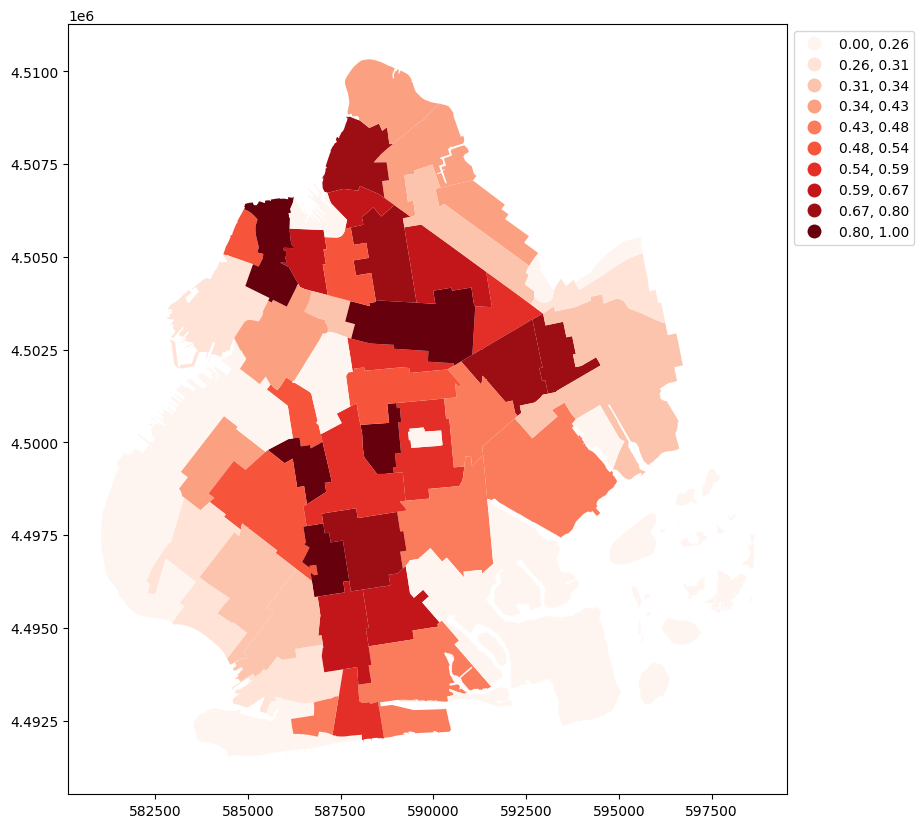

In [53]:
fig, ax = plt.subplots(figsize = (10,10))
nta_surv.plot(column = 'avg_value_scaled',ax = ax,cmap='Reds', legend = True,k = 10, scheme = 'Quantiles',
                missing_kwds={"color": "lightgrey", ## what to do with missing values
                                 "edgecolor": "red",
                                 "hatch": "///",
                                 "label": "Missing values",}
             ,legend_kwds={'bbox_to_anchor': (1, 1),'loc': 'upper left'})

In [54]:
features = []
for item in data[0]:
    geometry = shape(item['geojson'])
    properties = item['results']
    features.append({"geometry": geometry, "properties": properties})

blk_surv = gpd.GeoDataFrame.from_features(features)
blk_surv.head()

,geometry,CB2020,BoroCode,BoroName,CT2020,BCTCB2020,GEOID,Shape_Leng,Shape_Area,avg_value,std_dev_value,sample_size,avg_value_scaled,std_dev_scaled,quartile_buckets,quartile_labels
0,"MULTIPOLYGON (((584592.064 4502419.952, 584591...",1,3,Brooklyn,1801,30018010001,360470018010001,1061.915908,14961.031969,1.853225e-10,8.510260e-10,7105,0.009980,0.045831,Q1,Bottom 25%
1,"MULTIPOLYGON (((582738.379 4500475.968, 582748...",1,3,Brooklyn,1803,30018030001,360470018030001,4053.894954,83041.203647,4.333171e-11,2.026676e-10,21120,0.002334,0.010915,Q1,Bottom 25%
2,"MULTIPOLYGON (((582168.929 4499738.822, 582146...",1,3,Brooklyn,1804,30018040001,360470018040001,653.460985,3891.785188,8.548052e-12,3.810951e-11,1680,0.000460,0.002052,Q1,Bottom 25%
3,"POLYGON ((581453.732 4499145.540, 581447.007 4...",1,3,Brooklyn,3400,30034000001,360470034000001,1292.527355,35171.987124,2.219246e-10,4.410400e-10,3654,0.011952,0.023752,Q1,Bottom 25%
4,"MULTIPOLYGON (((583014.760 4503038.093, 583010...",1,3,Brooklyn,5301,30053010001,360470053010001,563.499018,6125.607515,3.002984e-11,1.856010e-10,2905,0.001617,0.009995,Q1,Bottom 25%


<Axes: >

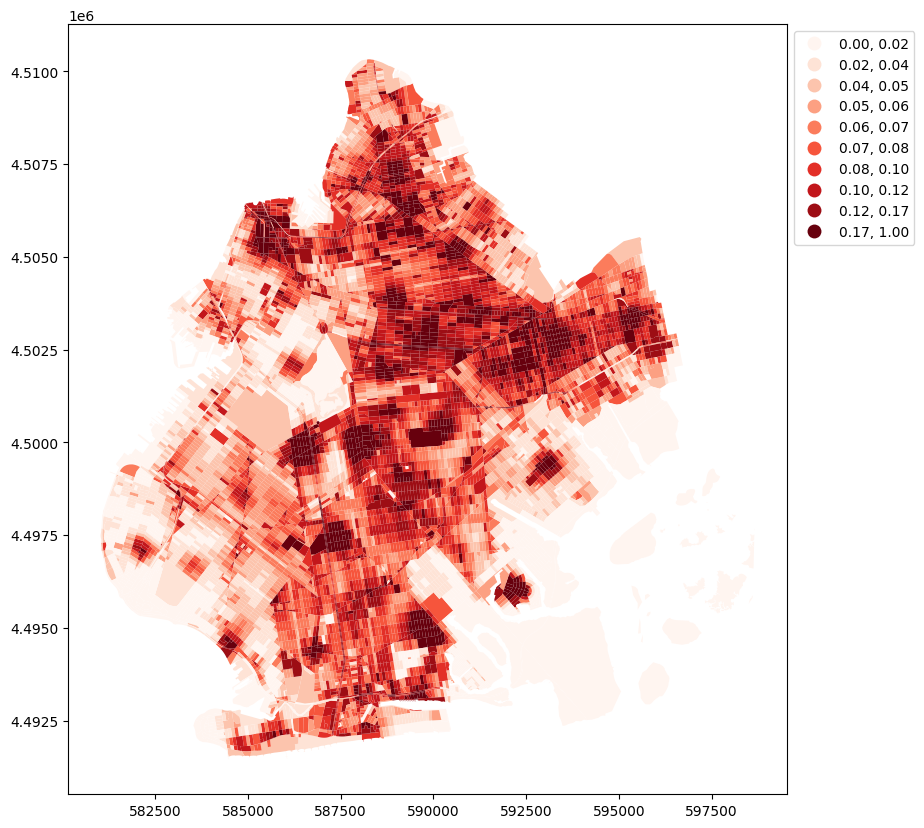

In [55]:
fig, ax = plt.subplots(figsize = (10,10))
blk_surv.plot(column = 'avg_value_scaled',ax = ax,cmap='Reds', legend = True,k = 10, scheme = 'Quantiles',
                missing_kwds={"color": "lightgrey", ## what to do with missing values
                                 "edgecolor": "red",
                                 "hatch": "///",
                                 "label": "Missing values",}
             ,legend_kwds={'bbox_to_anchor': (1, 1),'loc': 'upper left'})

In [56]:
features = []
for item in data[1]:
    geometry = shape(item['geojson'])
    properties = item['results']
    features.append({"geometry": geometry, "properties": properties})

trt_surv = gpd.GeoDataFrame.from_features(features)
trt_surv.head()

,geometry,CTLabel,BoroCode,BoroName,CT2020,BoroCT2020,CDEligibil,NTAName,NTA2020,CDTA2020,...,GEOID,Shape_Leng,Shape_Area,avg_value,std_dev_value,sample_size,avg_value_scaled,std_dev_scaled,quartile_buckets,quartile_labels
0,"POLYGON ((585247.472 4506029.684, 585252.447 4...",1.00,3,Brooklyn,100,3000100,None,Brooklyn Heights,BK0201,BK02,...,36047000100,6611.443960,2.224101e+06,1.711508e-09,2.886487e-09,95937,0.118447,0.199763,Q3,Median to Top 25%
1,"POLYGON ((584007.655 4500982.266, 583958.881 4...",2.00,3,Brooklyn,200,3000200,None,Sunset Park (West),BK0702,BK07,...,36047000200,9075.285121,2.952085e+06,9.131503e-10,1.816372e-09,160820,0.063196,0.125704,Q1,Bottom 25%
2,"POLYGON ((584966.437 4505778.759, 584940.848 4...",3.01,3,Brooklyn,301,3000301,None,Brooklyn Heights,BK0201,BK02,...,36047000301,6525.111338,2.164337e+06,9.005784e-10,1.460793e-09,94458,0.062326,0.101096,Q1,Bottom 25%
3,"POLYGON ((585075.427 4505660.913, 585012.652 4...",5.01,3,Brooklyn,501,3000501,None,Brooklyn Heights,BK0201,BK02,...,36047000501,4828.170276,9.015070e+05,7.750919e-10,2.257502e-09,50568,0.053641,0.156233,Q1,Bottom 25%
4,"POLYGON ((585215.411 4505612.714, 585223.049 4...",5.02,3,Brooklyn,502,3000502,None,Brooklyn Heights,BK0201,BK02,...,36047000502,4902.479685,1.041529e+06,2.378376e-09,5.227909e-09,48573,0.164598,0.361803,Q4,Top 25%


<Axes: >

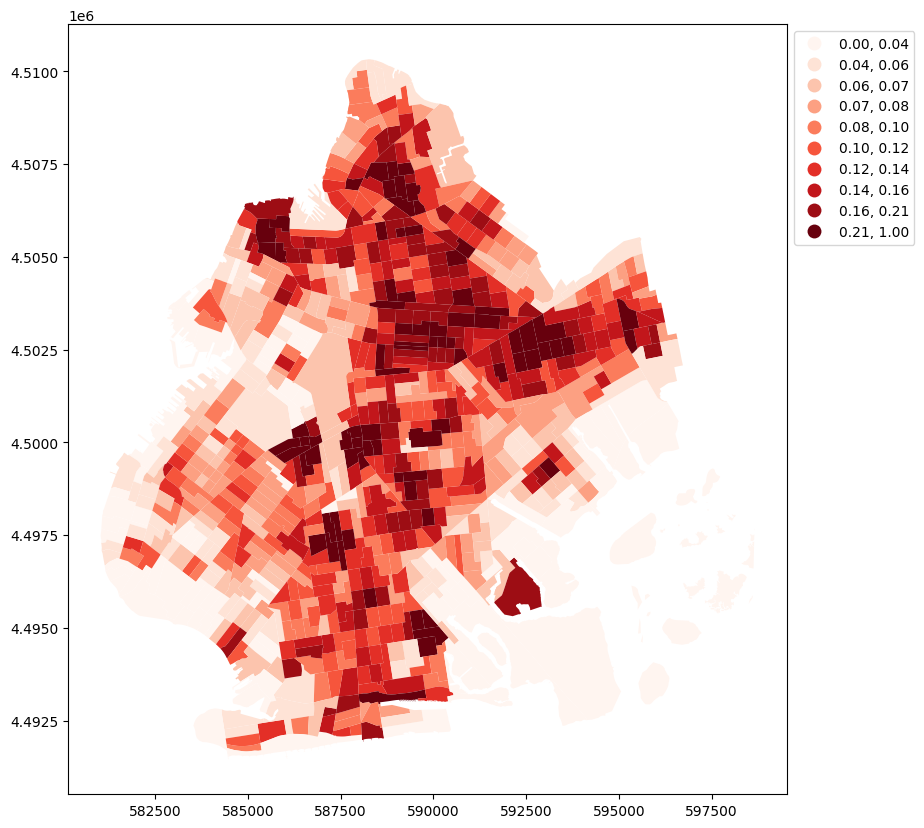

In [57]:
fig, ax = plt.subplots(figsize = (10,10))
trt_surv.plot(column = 'avg_value_scaled',ax = ax,cmap='Reds', legend = True,k = 10, scheme = 'Quantiles',
                missing_kwds={"color": "lightgrey", ## what to do with missing values
                                 "edgecolor": "red",
                                 "hatch": "///",
                                 "label": "Missing values",}
             ,legend_kwds={'bbox_to_anchor': (1, 1),'loc': 'upper left'})